## The task

1. We will try to create a model for predicting whether a student will pass or fail an exam (classification) based on the number of study hours and their scores in the previous exam.
2. The dataset is downloaded from kaggle.com - [dataset](https://www.kaggle.com/datasets/mrsimple07/student-exam-performance-prediction)

## The dataset

In [2]:
# Importing needed libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# reading the dataset
df = pd.read_csv("student_exam_data.csv")

In [4]:
# Let's display some info about dataset 
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Study Hours          500 non-null    float64
 1   Previous Exam Score  500 non-null    float64
 2   Pass/Fail            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


None

**Describing the Features:**

- *Study Hours (numeric):* Represents the number of hours a student spent studying for the upcoming exam.

- *Previous Exam Score (numeric):* Indicates the student's score in the previous exam.

- *Pass/Fail (binary):* The target variable, where 1 represents a pass and 0 represents a fail in the current exam.


### Descriptive statistics

With univariate analysis let's explore each variable (not target one) in our dataset. `Study Hours` and `Previous Exam Score` are numerical features, therefore we will be using Box-plot for visualisation.

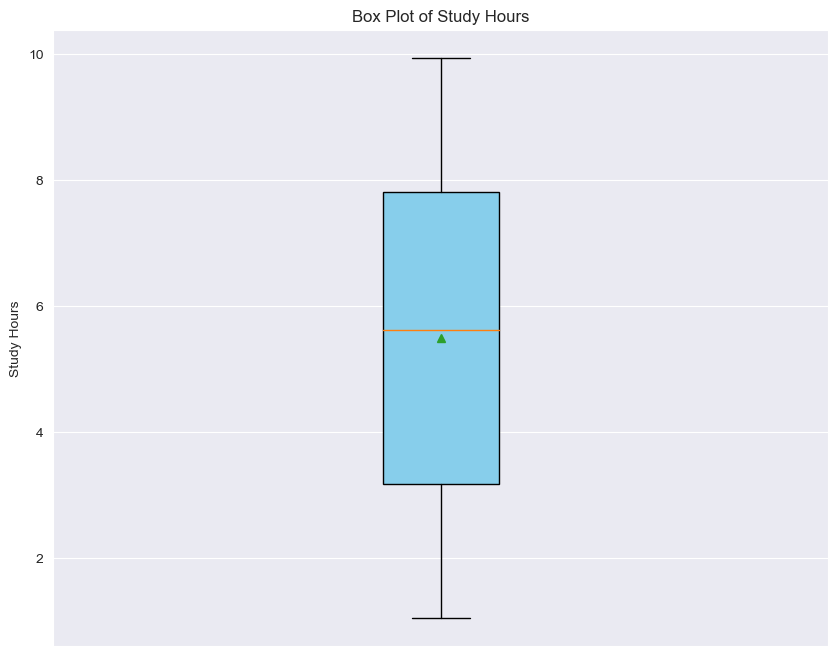

In [5]:
# Plotting the box plot of Study Hours
plt.figure(figsize=(10, 8))

plt.boxplot(df['Study Hours'], vert=True, showmeans=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))

plt.title('Box Plot of Study Hours')
plt.ylabel('Study Hours')

plt.xticks([])

plt.show()

From the visualisation we can see there is no outliers in `Study Hours` feature. The box itself represents the interquartile range, which is the range between the first quartile (Q1) and the third quartile (Q3) of the data. The length of the box indicates the spread of the middle 50% of the data. So 50% of people study from ~3.7 to 7.9 hours. The line inside the box represents the median and a green triangular shows an average value, which is, by the way, around 5.5 hours.

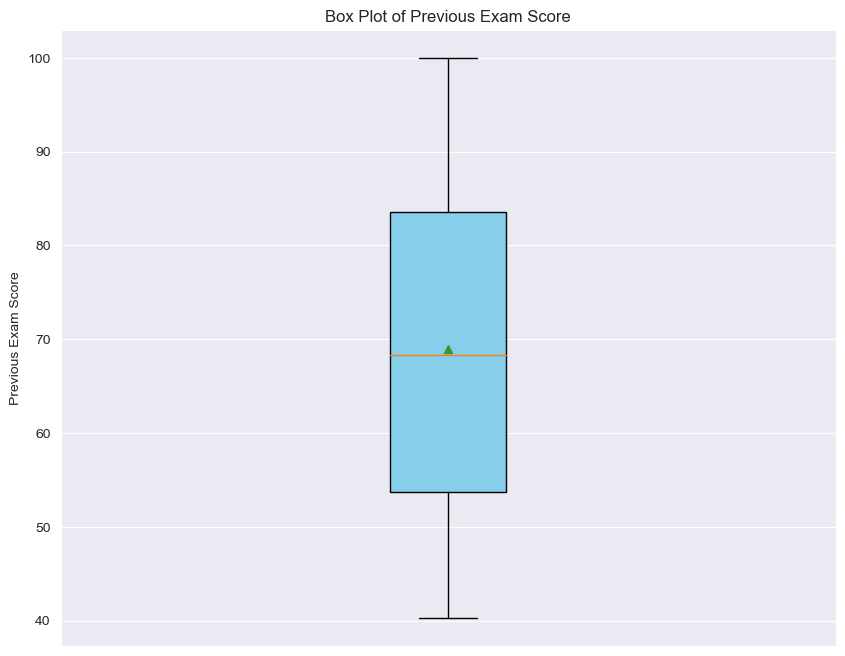

In [6]:
# Plotting the box plot of Previous Exam Score
plt.figure(figsize=(10, 8))

plt.boxplot(df['Previous Exam Score'], vert=True, showmeans=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))

plt.title('Box Plot of Previous Exam Score')
plt.ylabel('Previous Exam Score')

plt.xticks([])

plt.show()

Feature `Previous Exam Score` has no outliers as well. Middle 50% of the data lies in interval from ~55 to ~84 points. The average value is around 68.  

Let's draw heatmap to examine relationships between features (bivariate analysis).

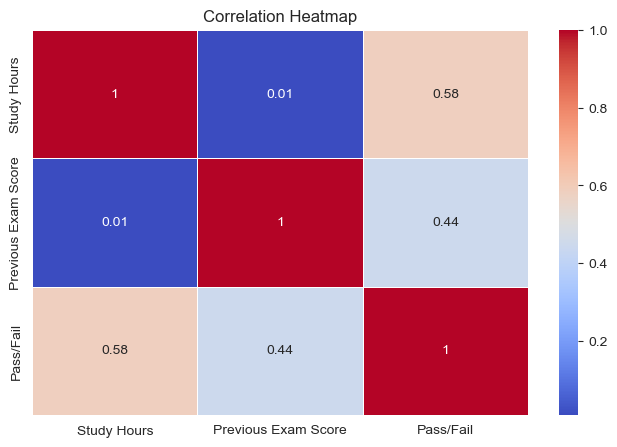

In [7]:
# Calculating the correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(8, 5))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Heatmap')

plt.show()

From the correlation heatmap we can see that there is positive correlation between target variable and features. However, `Study Hours` influences more successful completion of the exam (0.58 value) than `Previous Exam Score` with value 0.44.

Dependency between features almost does not exist (0.01).

There are no missing values in out dataset as well as outliers, so we do not need to deal with them.

Now let's divide the dataset into the target variable that we want to predict and the matrix of features from which we will predict. In our case, the target variable is Pass/Fail.

In [8]:
Xdata = df.drop('Pass/Fail', axis=1)
Ydata = df['Pass/Fail']

In [9]:
print("Xdata's shape -", Xdata.shape)
print("Ydata's shape -", Ydata.shape)

Xdata's shape - (500, 2)
Ydata's shape - (500,)


Then we divide the data into training (80%) and testing (20%) parts. There is no need of keeping the chronological or any other order of data, therefore for pseudorandom division of data we can use function train_test_split from sklearn. 

In [10]:
seed = 13

Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.2, random_state=seed)

In [11]:
print("Xtrain's shape -", Xtrain.shape)
print("Ytrain's shape -", Ytrain.shape)
print(25*'-')
print("Xtest's shape -", Xtest.shape)
print("Ytest's shape -", Ytest.shape)

Xtrain's shape - (400, 2)
Ytrain's shape - (400,)
-------------------------
Xtest's shape - (100, 2)
Ytest's shape - (100,)


## Creating the model

For our task Adaboost classifier with decision trees can suit us well, so let's choose it. AdaBoost (Adaptive Boosting) is an ensemble learning method that combines the predictions of multiple weak learners (in our case decision trees) to create a strong learner.   

The hyperparameters that we will tune:

- *n_estimators:* This parameter determines the number of weak learners (trees) that will be trained. Increasing the number of estimators generally improves the performance of the model, but it also increases the computational cost.
- *learning_rate:*  It is used to slow down training and to prevent overfitting of the model (if less than one).  

For binary classification problems (two classes), the binary cross-entropy loss function is often used, so be it. 

It is defined as:  

L(y,yˆ) = - y * log(yˆ) - (1 - y) * log(1 - yˆ), where  

- y is the true class label (0 or 1),
- yˆ is the predicted probability by model of belonging to class 1. 

During the training, we will try to minimize the error of prediction, which is calculated by the average value of loss function on training data:

L = 1/N * sum_i_from_1_to_N(L(Yi, Yˆ(xi)), where
training data is N pairs (Yi, xi).   

In [12]:
# Defining the base estimator (decision tree), default option
base_estimator = DecisionTreeClassifier(max_depth=1)

# Creating the AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator,random_state=seed)

# Defining the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Performing grid search (5-fold cross-validation)
grid_search = GridSearchCV(adaboost_classifier, param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(Xtrain, Ytrain)

# Getting the best hyperparameters
best_n_estimators = grid_search.best_params_['n_estimators']
best_learning_rate = grid_search.best_params_['learning_rate']
best_score = grid_search.best_score_

# Display
print(f"The best hyperparameters with score {best_score:.3f}:")
print("n_estimators - ", best_n_estimators, '')
print("learning_rate - ", best_learning_rate)


# Training the final model with the best hyperparameters
final_adaboost_model = AdaBoostClassifier(estimator=base_estimator,
                                          n_estimators=best_n_estimators,
                                          learning_rate=best_learning_rate,
                                          random_state=seed)
final_adaboost_model.fit(Xtrain, Ytrain);

The best hyperparameters with score -0.060:
n_estimators -  150 
learning_rate -  1.0


Because scikit-learn convention "the greater is better" we use negative log loss - "scoring='neg_log_loss'" (Log loss is something we want to minimize, so we have to make it negative in case of GridSearchCV). Because of that score is negative.

Let's visualise the score of our model for each set of hyperparameters.

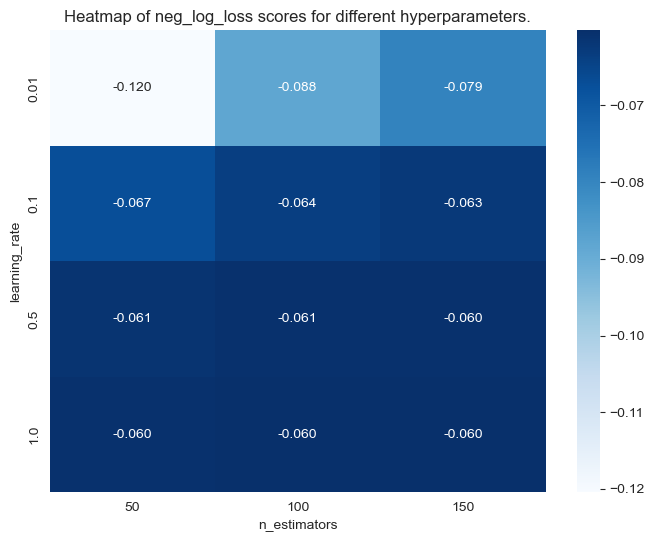

In [13]:
# Extracting the results of the grid search
results = grid_search.cv_results_
n_estimators_values = param_grid['n_estimators']
learning_rate_values = param_grid['learning_rate']

scores_matrix = np.array(results['mean_test_score']).reshape(len(learning_rate_values), len(n_estimators_values))

# Visualizing the scores using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(scores_matrix, annot=True, fmt=".3f", xticklabels=n_estimators_values, yticklabels=learning_rate_values, cmap="Blues")

plt.title('Heatmap of neg_log_loss scores for different hyperparameters.')
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')

plt.show()

From the heatmap we can see that mean cross-validated score is higher, when learning rate and number of decision trees inside ensemble model are higher.

So parameters with the highest score are n_estimators - 150, learning_rate - 1.0. Score is -0.060, which is almost perfect result. The score might improve after fitting the model on the whole train dataset (It hasn't been done during cross-validation!)

## Precision of the final model

In [14]:
print("accuracy score (train): {0:.6f}".format(metrics.accuracy_score(Ytrain, final_adaboost_model.predict(Xtrain))))
print("accuracy score (test): {0:.6f}".format(metrics.accuracy_score(Ytest, final_adaboost_model.predict(Xtest))))

accuracy score (train): 1.000000
accuracy score (test): 1.000000


In [15]:
print("logarithmic loss score (train): {0:.6f}".format(metrics.log_loss(Ytrain, final_adaboost_model.predict(Xtrain))))
print("logarithmic loss score (test): {0:.6f}".format(metrics.log_loss(Ytest, final_adaboost_model.predict(Xtest))))

logarithmic loss score (train): 0.000000
logarithmic loss score (test): 0.000000


After fitting the model with the best hyperparameters on the whole training dataset, it has reached perfect accuracy on training and testing parts of dataset, so the log_loss is 0.  

Let's draw ROC line and visualise confusion matrix on testing dataset, despite the fact, that we already know how they will look like.

In [16]:
# calculating probability of our prediction on test data
Ytest_prob = final_adaboost_model.predict_proba(Xtest)
# getting one column (probability of 1)
Ytest_prob1 = Ytest_prob[:,1]

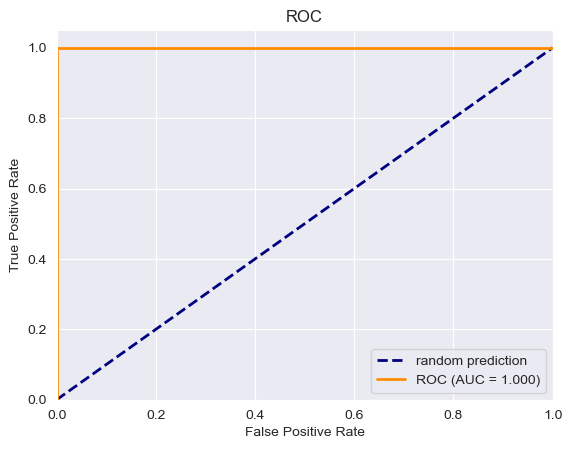

In [17]:
FPR, TPR, thresholds = metrics.roc_curve(Ytest, Ytest_prob1)

# calculating AUC
AUC = metrics.roc_auc_score(Ytest, Ytest_prob1)

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label = "random prediction")
plt.plot(FPR, TPR, color="darkorange", lw=2, label = f"ROC (AUC = {AUC:.3f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.show()

Area Under Curve (AUC) score shows how well the classifier distinguishes positive and negative classes. It can take values from 0 to 1. A higher AUC indicates better performance. As we already know our model predicts perfectly on testing dataset, so AUC = 1.000.

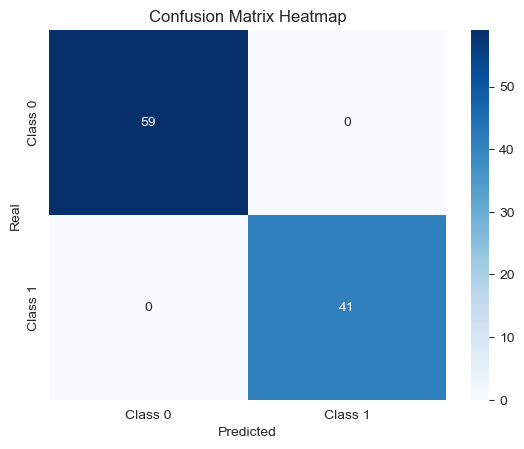

In [18]:
cm = confusion_matrix(Ytest, final_adaboost_model.predict(Xtest))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix Heatmap')

plt.show()

False Negatives (FN) and False Positive (FP) are 0, as we have expected.